# Dropsondes dataset JOANNE

The following script exemplifies the access and usage of dropsonde data measured 
during EUREC4A - ATOMIC.  

More information on the dataset can be found at https://github.com/Geet-George/JOANNE/tree/master/joanne/Level_3#level---3.
If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` and `author`.

## Get data
* To load the data we first load the EUREC4A meta data catalogue. More information on the catalog can be found [here](https://github.com/eurec4a/eurec4a-intake#eurec4a-intake-catalogue).

In [1]:
import datetime
import numpy as np
import eurec4a
cat = eurec4a.get_intake_catalog()

* We can funrther specify the platform, instrument, if applicable dataset level or variable name, and pass it on to dask.

```{note}
Have a look at the attributes of the xarray dataset `ds` for all relevant information on the dataset, such as author, contact, or citation infromation.
```

In [2]:
ds = cat.dropsondes.JOANNE.level3.to_dask()
ds

<xarray.Dataset>
Dimensions:          (alt: 1001, nv: 2, sounding: 1064)
Coordinates:
  * alt              (alt) int64 0 10 20 30 40 50 ... 9960 9970 9980 9990 10000
    lat              (sounding, alt) float32 dask.array<chunksize=(266, 501), meta=np.ndarray>
    launch_time      (sounding) datetime64[ns] dask.array<chunksize=(1064,), meta=np.ndarray>
    lon              (sounding, alt) float32 dask.array<chunksize=(266, 501), meta=np.ndarray>
  * sounding         (sounding) int64 0 1 2 3 4 5 ... 1059 1060 1061 1062 1063
Dimensions without coordinates: nv
Data variables: (12/19)
    N_gps            (sounding, alt) float32 dask.array<chunksize=(266, 501), meta=np.ndarray>
    N_ptu            (sounding, alt) float32 dask.array<chunksize=(266, 501), meta=np.ndarray>
    PW               (sounding) float32 dask.array<chunksize=(1064,), meta=np.ndarray>
    alt_bnds         (alt, nv) float64 dask.array<chunksize=(1001, 2), meta=np.ndarray>
    flight_height    (sounding) float32 dask.array<chunksize=(1064,), meta=np.ndarray>
    flight_lat       (sounding) float32 dask.array<chunksize=(1064,), meta=np.ndarray>
    ...               ...
    ta               (sounding, alt) float32 dask.array<chunksize=(266, 501), meta=np.ndarray>
    theta            (sounding, alt) float32 dask.array<chunksize=(266, 501), meta=np.ndarray>
    u                (sounding, alt) float32 dask.array<chunksize=(266, 501), meta=np.ndarray>
    v                (sounding, alt) float32 dask.array<chunksize=(266, 501), meta=np.ndarray>
    wdir             (sounding, alt) float32 dask.array<chunksize=(266, 501), meta=np.ndarray>
    wspd             (sounding, alt) float32 dask.array<chunksize=(266, 501), meta=np.ndarray>
Attributes: (12/13)
    ASPEN-version:           BatchAspen v3.4.3
    AVAPS-Software-version:  Version 4.1.2
    Conventions:             CF-1.8
    JOANNE-version:          0.7.0+2.g4a878b3.dirty
    author:                  Geet George
    author_email:            geet.george@mpimet.mpg.de
    ...                      ...
    creation_time:           2020-08-06 09:58:16.927582 UTC
    featureType:             trajectory
    instrument_id:           Vaisala RD-41
    product_id:              Level-3
    project_id:              JOANNE
    title:                   EUREC4A JOANNE Level-3

## Load HALO flight phase information
All HALO flights were split up into flight phases or segments to allow for a precise selection in time and space of a circle or calibration pattern. For more information have a look at the respective [github repository](https://github.com/eurec4a/flight-phase-separation#segmentation-of-flights-during-eurec4a).

In [3]:
meta = eurec4a.get_flight_segments()

In [4]:
segments = [{**s,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for s in flight["segments"]
           ]

In [5]:
segments_by_segment_id = {s["segment_id"]: s for s in segments}

In [6]:
segments_ordered_by_start_time = list(sorted(segments, key=lambda s: s["start"]))

We select all `dropsondes` with the quality flag `GOOD` from the first circle on February 5.

In [7]:
first_circle_Feb05 = [s["segment_id"]
                 for s in segments_ordered_by_start_time
                 if "circle" in s["kinds"]
                 and s["start"].date() == datetime.date(2020,2,5)
                 and s["platform_id"] == "HALO"
                ][0]
first_circle_Feb05

'HALO-0205_c1'

In [8]:
dropsonde_ids = segments_by_segment_id[first_circle_Feb05]["dropsondes"]["GOOD"]
dropsonde_ids

['HALO-0205_s01',
 'HALO-0205_s02',
 'HALO-0205_s03',
 'HALO-0205_s04',
 'HALO-0205_s05',
 'HALO-0205_s06',
 'HALO-0205_s07',
 'HALO-0205_s08',
 'HALO-0205_s09',
 'HALO-0205_s10',
 'HALO-0205_s12']

We transfer the information from our flight segment selection to the dropsondes data in the xarray dataset.

In [9]:
from functools import reduce
mask_sondes_first_circle_Feb05 = reduce(lambda a, b: a | b, [ds.sonde_id==d
                                                             for d in dropsonde_ids])
ds_sondes_first_circle_Feb05 = ds.isel(sounding=mask_sondes_first_circle_Feb05)

## Plots
You can get a list of available variables in the dataset from `ds.variables.keys()`  

```{note}
fetching the data and displaying it might take a few seconds
```

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("./mplstyle/book")

### Temperature and relative humidity as stored in the xarray dataset

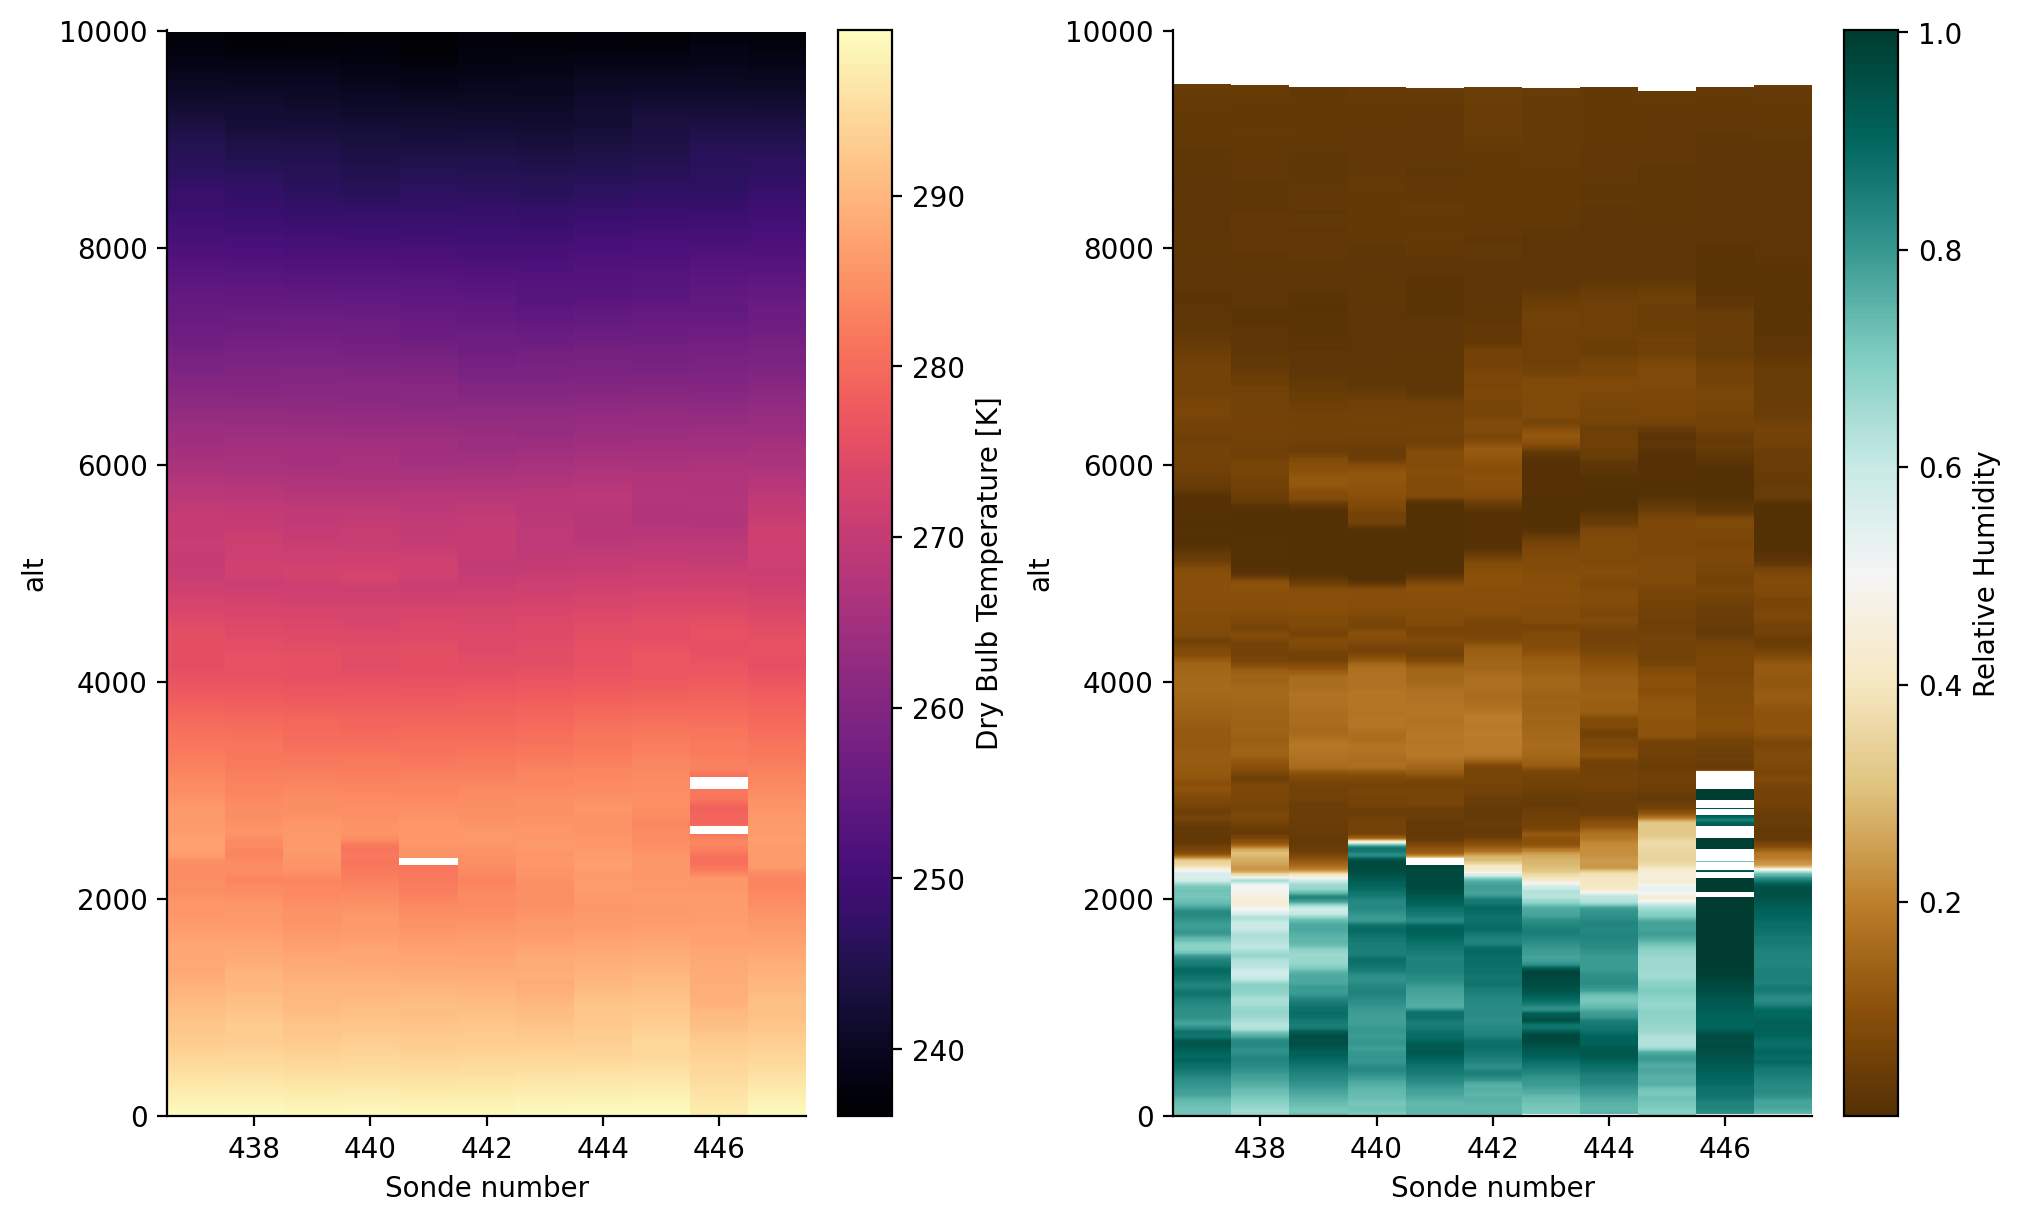

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ds_sondes_first_circle_Feb05.ta.transpose("alt", "sounding").plot(ax=ax0, cmap="magma")
ds_sondes_first_circle_Feb05.rh.transpose("alt", "sounding").plot(ax=ax1, cmap="BrBG")
None

### Temperature and relative humidity profiles.
The temperature profiles are colored according to their launch time, while relative humidity profiles are colored according to their integrated water vapour in the measured column, i.e. precipitable water.

In [12]:
def dt64_to_dt(dt64):
    epoch = np.datetime64('1970-01-01T00:00:00')
    second = np.timedelta64(1, 's')
    return datetime.datetime.utcfromtimestamp(int((dt64 - epoch) / second))

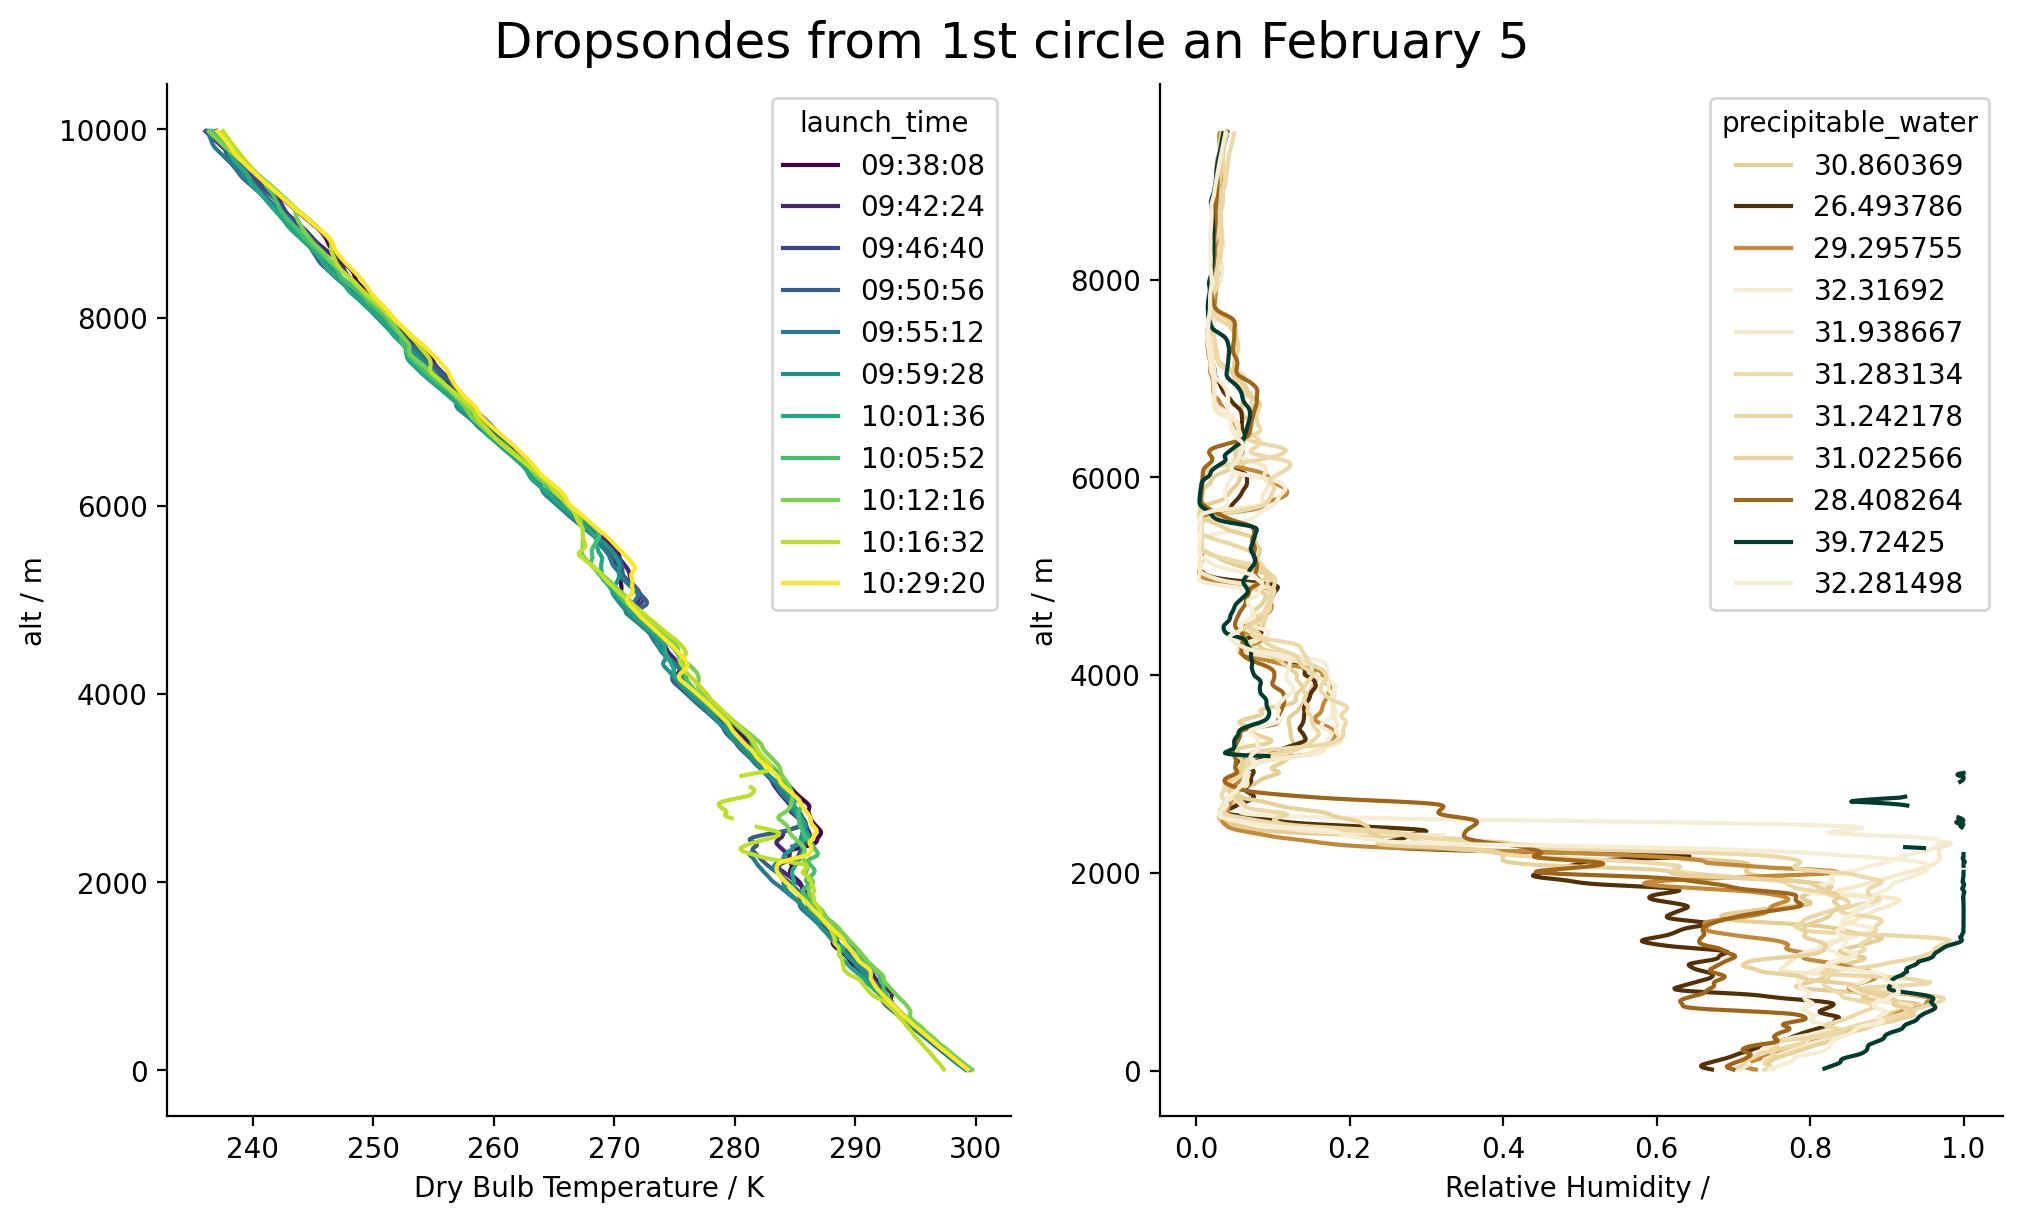

In [13]:
fig, (ax0, ax1) = plt.subplots(1, 2)

y = ds_sondes_first_circle_Feb05.alt

x0 = ds_sondes_first_circle_Feb05.ta.transpose("alt", "sounding")
ax0.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(dropsonde_ids))))
ax0.plot(x0, y.data[:, np.newaxis])
ax0.set_xlabel(f"{x0.long_name} / {x0.units}")
ax0.set_ylabel(f"{y.name} / m")
ax0.legend([dt64_to_dt(d).strftime("%H:%M:%S")
            for d in ds_sondes_first_circle_Feb05.launch_time],
           title=x0.launch_time.name)

x1 = ds_sondes_first_circle_Feb05.rh.transpose("alt", "sounding")
c = ds_sondes_first_circle_Feb05.PW

ax1.set_prop_cycle(color=plt.cm.BrBG([int(i) for i in (c - c.min())#cividis_r
                                           / (c - c.min()).max() * 255]))
p = ax1.plot(x1, y.data[:, np.newaxis])
ax1.set_xlabel(f"{x1.long_name} / {x1.units}")
ax1.set_ylabel(f"{y.name} / m")
ax1.legend(ds_sondes_first_circle_Feb05.PW.values,
           title=ds_sondes_first_circle_Feb05.PW.standard_name)

fig.suptitle('Dropsondes from 1st circle an February 5', fontsize=18)
None

### wind speed variations throughout February 5

In [14]:
mask_sondes_Feb05 = ds.launch_time.astype("<M8[D]") == np.datetime64("2020-02-05")
ds_sondes_Feb05 = ds.isel(sounding=mask_sondes_Feb05)

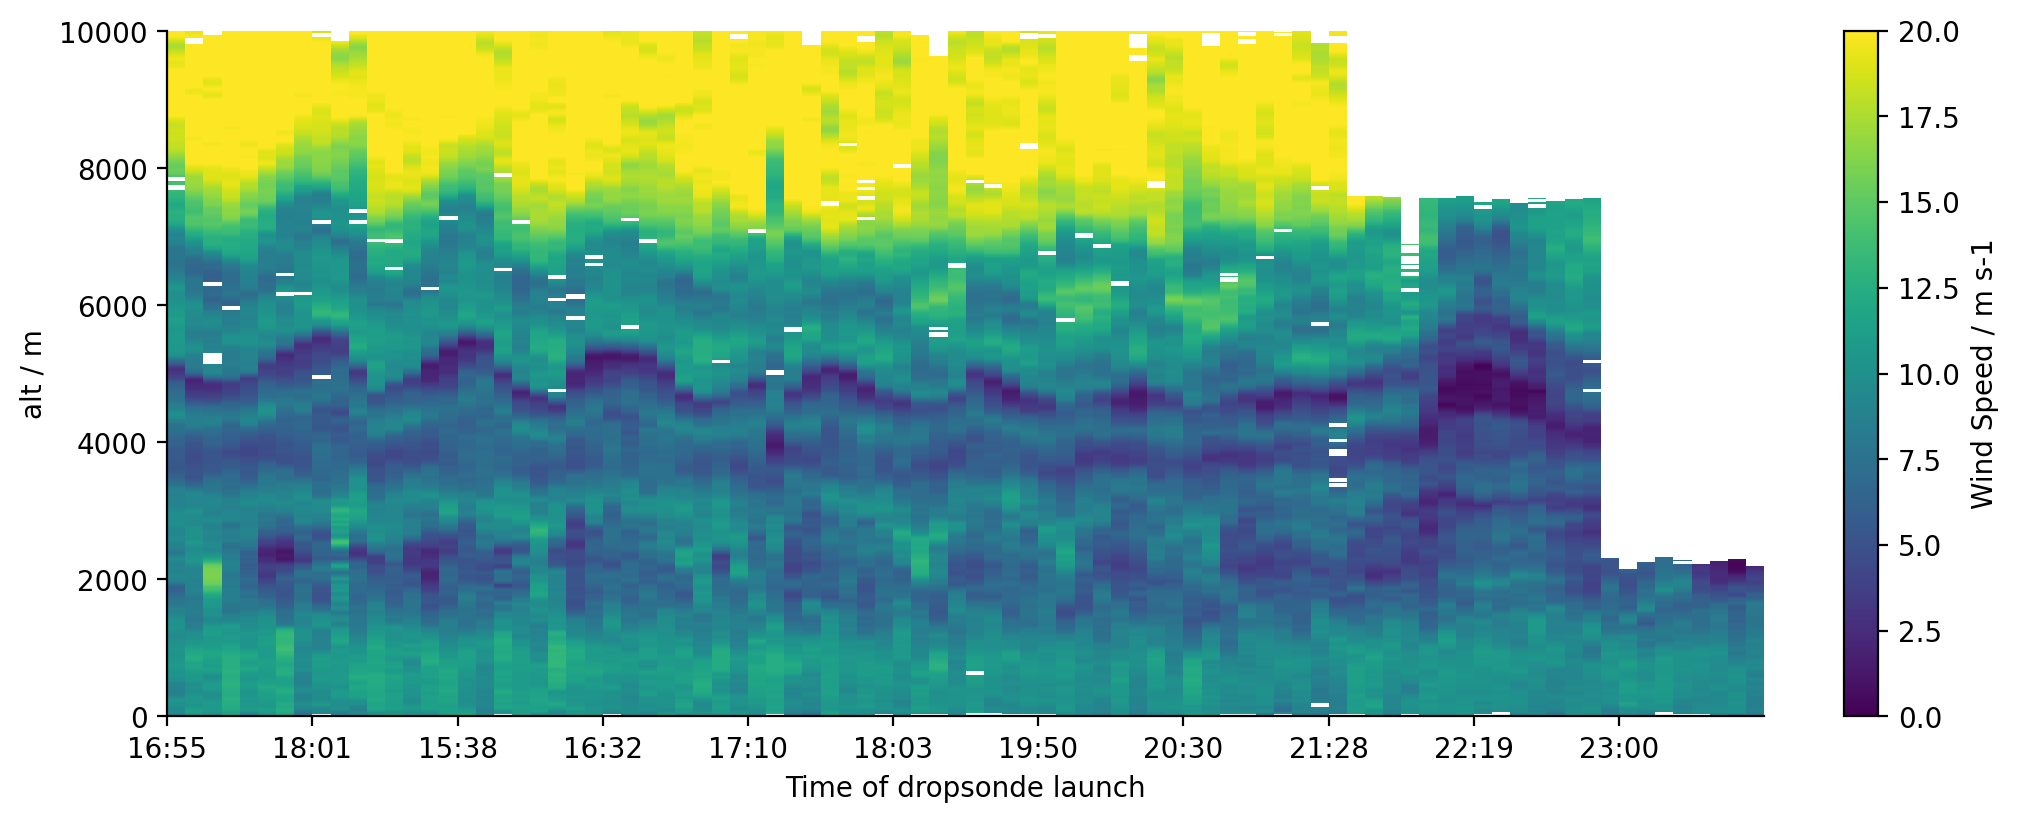

In [15]:
with plt.style.context("mplstyle/wide"):
    fig, ax = plt.subplots()
    p = ax.pcolormesh(ds_sondes_Feb05.wspd.transpose("alt", "sounding"), vmin=0, vmax=20)
    plt.colorbar(p, ax=ax, label=f"{ds_sondes_Feb05.wspd.long_name} / {ds_sondes_Feb05.wspd.units}")
    xticks = np.arange(0, ds_sondes_Feb05.sounding.size, int(ds_sondes_Feb05.sounding.size/10))
    ax.set_xticks(xticks)
    ax.set_xticklabels([dt64_to_dt(t).strftime("%H:%M") for t in ds.launch_time.values[xticks]])
    ax.set_xlabel(f"{ds_sondes_Feb05.launch_time.long_name}")
    yticks = np.arange(0, ds_sondes_Feb05.alt.size, int(ds_sondes_Feb05.alt.size/5))
    ax.set_yticks(yticks)
    ax.set_yticklabels(ds_sondes_Feb05.alt.values[yticks])
    ax.set_ylabel(f"{ds_sondes_Feb05.alt.name} / m")
    None